In [1]:
%matplotlib inline

In [146]:
import numpy as np
import pandas as pd
from sparsesvd import sparsesvd 
from scipy.sparse import csc_matrix
import seaborn as sns; sns.set()
import numba as nb
from numba import jit, vectorize, float64, int64
from sklearn.decomposition import SparsePCA

In [3]:
def argminBIC(lambdas, w_inv_nonzero, cand_nonzero, index, X, sigma_sq, n, d, old, isV):
    """index for lowest BIC"""
    BICs = np.ones(lambdas.shape[0]-1)*np.Inf
    for i in range(BICs.shape[0]):
        temp_partial = update(cand_nonzero, lambdas[i])/w_inv_nonzero
        if(isV==1):
            temp = np.zeros((d,1))
            temp[index] = temp_partial
            pred = old@temp.T
        else:
            temp = np.zeros((n,1))
            temp[index] = temp_partial
            pred = temp@old.T
        BICs[i] = np.sum((X-pred)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
    best = np.argmin(BICs)
    return best

In [4]:
def update(candidate, penalty):
    """update v or u for SSVD"""
    return np.sign(candidate)*(np.abs(candidate)>= penalty)*(np.abs(candidate) - penalty)

In [5]:
def SSVD_function(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)

    # initiations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        ## Update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xu_w = Xu*w2_inv                                  # X.T @ u/w
        lambda2s = np.unique(np.append(np.abs(Xu_w), 0))
        lambda2s.sort()                                   # possible lambda2/2
        index = np.where(w2_inv>1e-8)
        w2_inv_nonzero = w2_inv[index]
        Xu_w_nonzero = Xu_w[index]

        # best lambda and new v
        best = argminBIC(lambda2s, w2_inv_nonzero, Xu_w_nonzero, index, X, sigma_sq, n, d, old=u, isV=1)
        lambda2 = lambda2s[best]
        v_new_partial = update(Xu_w_nonzero, lambda2)/w2_inv_nonzero
        v_new = np.zeros((d,1))
        v_new[index] = v_new_partial
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        # update v
        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new

        ## Update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-n)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xv_w = Xv*w1_inv                                  # X.T @ u/w
        lambda1s = np.unique(np.append(np.abs(Xv_w), 0))
        lambda1s.sort()                                   # possible lambda2/2
        index = np.where(w1_inv>1e-8)
        w1_inv_nonzero = w1_inv[index]
        Xv_w_nonzero = Xv_w[index]

        # best lambda and new u
        best = argminBIC(lambda1s, w1_inv_nonzero, Xv_w_nonzero, index, X, sigma_sq, n, d, old=v, isV=0)
        lambda1 = lambda1s[best]
        u_new_partial = update(Xv_w_nonzero, lambda1)/w1_inv_nonzero
        u_new = np.zeros((n,1))
        u_new[index] = u_new_partial
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        # update u
        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new
        
        # check iteration
        if(niter > max_iter):
            print("Fail to converge")
        
    return(np.ravel(u), s, np.ravel(v), niter)

In [6]:
def SSVD_primary(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)
    
    # initializations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        # update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        lambda2s = np.unique(np.append(np.abs(Xu*w2_inv), 0))
        lambda2s.sort()                                   # possible lambda2/2

        # best BIC
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            v_temp = np.sign(Xu)*(np.abs(Xu) >= lambda2s[i] / w2_inv)*(np.abs(Xu) - lambda2s[i] / w2_inv)
            BICs[i] = np.sum((X-u@v_temp.T)**2)/sigma_sq/(n*d) + np.sum(v_temp!=0)*np.log(n*d)/(n*d)
        best = np.argmin(BICs)

        lambda2 = lambda2s[best]
        v_new = np.sign(Xu)*(np.abs(Xu) >= lambda2 / w2_inv)*(np.abs(Xu) - lambda2 / w2_inv)
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new


        # update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xv**2))/(n*d-n) 

        lambda1s = np.unique(np.append(np.abs(Xv*w1_inv), 0))
        lambda1s.sort()                                   # possible lambda1/2

        # best BIC
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            u_temp = np.sign(Xv)*(np.abs(Xv) >= lambda1s[i] / w1_inv)*(np.abs(Xv) - lambda1s[i] / w1_inv)
            BICs[i] = np.sum((X-u_temp@v.T)**2)/sigma_sq/(n*d) + np.sum(u_temp!=0)*np.log(n*d)/(n*d)
        best = np.argmin(BICs)

        lambda1 = lambda1s[best]
        u_new = np.sign(Xv)*(np.abs(Xv) >= lambda1 / w1_inv)*(np.abs(Xv) - lambda1 / w1_inv)
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new

        # check iterations
        if niter > max_iter:
            print("Fail to converge! Increase the max_iter!")
            break
    return(np.ravel(u), s, np.ravel(v), niter)

In [12]:
import multiprocessing as mp
from multiprocessing import Pool

from functools import partial

def BIC_v(lambda2, candidate, w_inv, X, u, sigma_sq, n, d):
    v_temp = np.sign(candidate)*(np.abs(candidate) >= lambda2 / w_inv)*(np.abs(candidate) - lambda2 / w_inv)
    BIC = np.sum((X-u@v_temp.T)**2)/sigma_sq/(n*d) + np.sum(v_temp!=0)*np.log(n*d)/(n*d)
    return BIC

def BIC_u(lambda1, candidate, w_inv, X, v, sigma_sq, n, d):
    u_temp = np.sign(candidate)*(np.abs(candidate) >= lambda1 / w_inv)*(np.abs(candidate) - lambda1 / w_inv)
    BIC = np.sum((X-u_temp@v.T)**2)/sigma_sq/(n*d) + np.sum(u_temp!=0)*np.log(n*d)/(n*d)
    return BIC

def SSVD_parallel_multi(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)
    
    # initializations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        # update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        lambda2s = np.unique(np.append(np.abs(Xu*w2_inv), 0))
        lambda2s.sort()                                   # possible lambda2/2

        # best BIC
        BIC_v_partial = partial(BIC_v, candidate = Xu, w_inv = w2_inv, X = X, u = u, sigma_sq = sigma_sq, n = n, d = d)
        with Pool(processes=4) as pool:
            BICs = pool.map(BIC_v_partial, lambda2s)
        best = np.argmin(BICs)

        lambda2 = lambda2s[best]
        v_new = np.sign(Xu)*(np.abs(Xu) >= lambda2 / w2_inv)*(np.abs(Xu) - lambda2 / w2_inv)
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new


        # update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xv**2))/(n*d-n) 

        lambda1s = np.unique(np.append(np.abs(Xv*w1_inv), 0))
        lambda1s.sort()                                   # possible lambda1/2

        # best BIC
        BIC_u_partial = partial(BIC_u, candidate = Xv, w_inv = w1_inv, X = X, v = v, sigma_sq = sigma_sq, n = n, d = d)
        with Pool(processes=4) as pool:
            BICs = pool.map(BIC_u_partial, lambda1s)
        best = np.argmin(BICs)

        lambda1 = lambda1s[best]
        u_new = np.sign(Xv)*(np.abs(Xv) >= lambda1 / w1_inv)*(np.abs(Xv) - lambda1 / w1_inv)
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new

        # check iterations
        if niter > max_iter:
            print("Fail to converge! Increase the max_iter!")
            break
    return(np.ravel(u), s, np.ravel(v), niter)

In [8]:
from ipyparallel import Client
rc = Client()
dv = rc[:]

@dv.parallel(block = True)
def BIC_v(lambda2, candidate, w_inv, X, u, sigma_sq, n, d):
    v_temp = np.sign(candidate)*(np.abs(candidate) >= lambda2 / w_inv)*(np.abs(candidate) - lambda2 / w_inv)
    BIC = np.sum((X-u@v_temp.T)**2)/sigma_sq/(n*d) + np.sum(v_temp!=0)*np.log(n*d)/(n*d)
    return BIC

@dv.parallel(block = True)
def BIC_u(lambda1, candidate, w_inv, X, v, sigma_sq, n, d):
    u_temp = np.sign(candidate)*(np.abs(candidate) >= lambda1 / w_inv)*(np.abs(candidate) - lambda1 / w_inv)
    BIC = np.sum((X-u_temp@v.T)**2)/sigma_sq/(n*d) + np.sum(u_temp!=0)*np.log(n*d)/(n*d)
    return BIC

def SSVD_ipyparallel(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)
    
    # initializations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        # update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        lambda2s = np.unique(np.append(np.abs(Xu*w2_inv), 0))
        lambda2s.sort()                                   # possible lambda2/2

        # best BIC
        BIC_v_partial = partial(BIC_v, candidate = Xu, w_inv = w2_inv, X = X, u = u, sigma_sq = sigma_sq, n = n, d = d)
        with Pool(processes=4) as pool:
            BICs = pool.map(BIC_v_partial, lambda2s)
        best = np.argmin(BICs)

        lambda2 = lambda2s[best]
        v_new = np.sign(Xu)*(np.abs(Xu) >= lambda2 / w2_inv)*(np.abs(Xu) - lambda2 / w2_inv)
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new


        # update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xv**2))/(n*d-n) 

        lambda1s = np.unique(np.append(np.abs(Xv*w1_inv), 0))
        lambda1s.sort()                                   # possible lambda1/2

        # best BIC
        BIC_u_partial = partial(BIC_u, candidate = Xv, w_inv = w1_inv, X = X, v = v, sigma_sq = sigma_sq, n = n, d = d)
        with Pool(processes=4) as pool:
            BICs = pool.map(BIC_u_partial, lambda1s)
        best = np.argmin(BICs)

        lambda1 = lambda1s[best]
        u_new = np.sign(Xv)*(np.abs(Xv) >= lambda1 / w1_inv)*(np.abs(Xv) - lambda1 / w1_inv)
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new

        # check iterations
        if niter > max_iter:
            print("Fail to converge! Increase the max_iter!")
            break
    return(np.ravel(u), s, np.ravel(v), niter)

TimeoutError: Hub connection request timed out

In [9]:
def SSVD_second(X, gamma1 = 2, gamma2 = 2, tol = 1e-4, max_iter = 100):
    """SSVD for 1 layer"""
    u, s, v = sparsesvd(csc_matrix(X), k=1)

    # initiations
    n = X.shape[0]
    d = X.shape[1]
    u = u.reshape((n,1))
    v = v.reshape((d,1))
    u_delta = 1
    v_delta = 1
    niter = 0
    SST = np.sum(X**2)
    
    while((u_delta > tol) or (v_delta > tol)):
        niter += 1

        ## Update v
        Xu = X.T @ u
        w2_inv = np.abs(Xu)**gamma2
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-d)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xu_w = Xu*w2_inv                                  # X.T @ u/w
        lambda2s = np.unique(np.append(np.abs(Xu_w), 0))
        lambda2s.sort()                                   # possible lambda2/2
        index = np.where(w2_inv>1e-8)
        w2_inv_nonzero = w2_inv[index]
        Xu_w_nonzero = Xu_w[index]

        # best lambda and new v
        BICs = np.ones(lambda2s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2s[i])*(np.abs(Xu_w_nonzero)-lambda2s[i])
            temp = np.zeros((d,1))
            temp[index] = temp_partial/w2_inv_nonzero
            BICs[i] = np.sum((X-u@temp.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda2 = lambda2s[best]
        v_new_partial = np.sign(Xu_w_nonzero)*(np.abs(Xu_w_nonzero)>=lambda2)*(np.abs(Xu_w_nonzero)-lambda2)/w2_inv_nonzero
        v_new = np.zeros((d,1))
        v_new[index] = v_new_partial
        v_new = v_new/np.sqrt(np.sum(v_new**2))

        # update v
        v_delta = np.sqrt(np.sum((v-v_new)**2))
        v = v_new

        ## Update u
        Xv = X @ v
        w1_inv = np.abs(Xv)**gamma1
        sigma_sq = np.abs(SST - sum(Xu**2))/(n*d-n)   #np.trace((X-s*u@v.T) @ (X-s*u@v.T).T)/(n*d-d)

        # prepare lambda and candicates
        Xv_w = Xv*w1_inv                                  # X.T @ u/w
        lambda1s = np.unique(np.append(np.abs(Xv_w), 0))
        lambda1s.sort()                                   # possible lambda2/2
        index = np.where(w1_inv>1e-8)
        w1_inv_nonzero = w1_inv[index]
        Xv_w_nonzero = Xv_w[index]

        # best lambda and new u
        BICs = np.ones(lambda1s.shape[0]-1)*np.Inf
        for i in range(BICs.shape[0]):
            temp_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1s[i])*(np.abs(Xv_w_nonzero)-lambda1s[i])
            temp = np.zeros((n,1))
            temp[index] = temp_partial/w1_inv_nonzero
            BICs[i] = np.sum((X-temp@v.T)**2)/sigma_sq + np.sum(temp_partial!=0)*np.log(n*d)
        best = np.argmin(BICs)
        lambda1 = lambda1s[best]
        u_new_partial = np.sign(Xv_w_nonzero)*(np.abs(Xv_w_nonzero)>=lambda1)*(np.abs(Xv_w_nonzero)-lambda1)/w1_inv_nonzero
        u_new = np.zeros((n,1))
        u_new[index] = u_new_partial
        u_new = u_new/np.sqrt(np.sum(u_new**2))

        # update u
        u_delta = np.sqrt(np.sum((u-u_new)**2))
        u = u_new
        
        # check iteration
        if(niter > max_iter):
            print("Fail to converge")
        
    return(np.ravel(u), s, np.ravel(v), niter)

## Paper Data

In [24]:
data = pd.read_csv('data/data.txt', sep=' ', header = None)
X = np.array(data.T)

In [11]:
%%time
u, s, v, niter = SSVD_primary(X)

CPU times: user 8min 28s, sys: 14min 47s, total: 23min 15s
Wall time: 2min 57s


In [14]:
%%time
u, s, v, niter = SSVD_second(X)

CPU times: user 9min 32s, sys: 20min 18s, total: 29min 51s
Wall time: 6min 31s


In [25]:
%%time
u, s, v, niter = SSVD_function(X)

CPU times: user 9min 13s, sys: 19min 22s, total: 28min 35s
Wall time: 7min 7s


In [13]:
%%time
u, s, v, niter = SSVD_parallel_multi(X)

CPU times: user 1.6 s, sys: 2.74 s, total: 4.34 s
Wall time: 3min 46s


In [15]:
n = X.shape[0]
d = X.shape[1]
first = s*u.reshape((n, 1))@v.reshape((1, d))

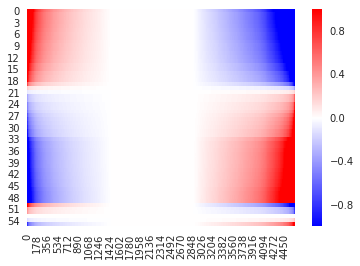

In [16]:
group1 = range(20)
group2 = range(20, 33)
group3 = range(33, 50)
group4 = range(50, 56)

row_idx = np.concatenate((np.argsort(u[group1]), np.argsort(u[group2])+20, np.argsort(u[group3])+33, np.argsort(u[group4])+50))
col_nonzero = np.argsort(np.abs(v))[8000:]
v_nonzero = v[col_nonzero]
first_nonzero = first[:,col_nonzero]
col_idx = np.argsort(v_nonzero)

ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')

## Simulation

In [92]:
u_tilde = np.r_[np.arange(3,11)[::-1], 2*np.ones(17), np.zeros(75)].reshape((-1,1))
u = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]),3*np.ones(5),-3*np.ones(5),np.zeros(34)].reshape((-1,1))
v = v_tilde/np.linalg.norm(v_tilde)
s = 50

X_star = s*u@v.T
n, d = X_star.shape
np.random.seed(2018)
X_sim = X_star + np.random.randn(n,d)

In [18]:
%%time 

u, s, v, niter = SSVD_primary(X_sim)

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 45.8 ms


In [19]:
%%time

u, s, v, niter = SSVD_second(X_sim)

CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 42.4 ms


In [20]:
%%time

u, s, v, niter = SSVD_function(X_sim)

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 49 ms


In [21]:
%%time 

u, s, v, niter = SSVD_parallel_multi(X_sim)

CPU times: user 64 ms, sys: 200 ms, total: 264 ms
Wall time: 1.1 s


In [22]:
X = X_sim
u, s, v, niter = SSVD_function(X)
n = X.shape[0]
d = X.shape[1]
first = s*u.reshape((n, 1))@v.reshape((1, d))

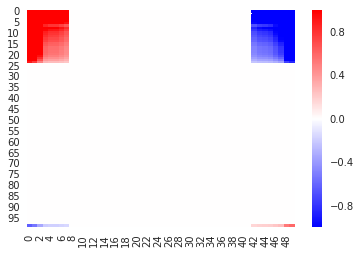

In [23]:
group1 = range(8)
group2 = range(8, 25)
group3 = range(25, 100)

row_idx = np.concatenate((np.argsort(u[group1]), np.argsort(u[group2])+8, np.argsort(u[group3])+25))
col_nonzero = np.argsort(np.abs(v))
v_nonzero = v[col_nonzero]
first_nonzero = first[:,col_nonzero]
col_idx = np.argsort(v_nonzero)

ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')

## Comparison

In [161]:
u_tilde = np.r_[np.arange(3,11)[::-1], 2*np.ones(17), np.zeros(75)].reshape((-1,1))
u = u_tilde/np.linalg.norm(u_tilde)
v_tilde = np.r_[np.array([10,-10,8,-8,5,-5]),3*np.ones(5),-3*np.ones(5),np.zeros(34)].reshape((-1,1))
v = v_tilde/np.linalg.norm(v_tilde)
s = 50

X_star = s*u@v.T
n, d = X_star.shape
np.random.seed(2018)
X_sim = X_star + np.random.randn(n,d)

In [162]:
u_sparsesvd, s, v_sparsesvd = sparsesvd(csc_matrix(X_sim), k=1)

In [163]:
u_SSVD, s, v_SSVD, niter = SSVD_primary(X_sim)

In [143]:
u_svd, s, v_svd = np.linalg.svd(X_sim)
u_svd = u_svd[:,0]
v_svd = v_svd[0,:]

In [148]:
SPAC = SparsePCA(n_components=1, alpha=2)
SPAC.fit(X_sim)
v_SPAC = SPAC.components_[0]
SPAC.fit(X_sim.T)
u_SPAC = SPAC.components_[0]

In [185]:
def evaluation(estimate, label):
    estimate = estimate.reshape(-1)
    label = label.reshape(-1)
    k = np.sum(label==0)
    n = label.shape[0]
    num_0 = np.sum(estimate==0)
    num_0_true = np.sum((estimate==0) & (label==0))
    p_0_true = num_0_true/k
    num_none0_true = np.sum((estimate!=0) & (label!=0))
    p_none0_true = num_none0_true/(n-k)
    miss_rate = (np.sum((estimate==0) & (label!=0)) + np.sum((estimate!=0) & (label==0)))/n
    return(num_0,num_0_true,p_0_true,num_none0_true,p_none0_true,miss_rate )

In [186]:
evaluation(u_SSVD, u)

(74, 74, 0.9866666666666667, 25, 1.0, 0.01)

## Outside data

In [60]:
data = pd.read_csv('data/BreastCancerData.txt', sep='\\t', header=0)
X = np.array(data.T)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [61]:
%%time
u, s, v, niter = SSVD_primary(X)

CPU times: user 4.62 s, sys: 4.17 s, total: 8.78 s
Wall time: 3.27 s


In [62]:
n = X.shape[0]
d = X.shape[1]
first = s*u.reshape((n, 1))@v.reshape((1, d))

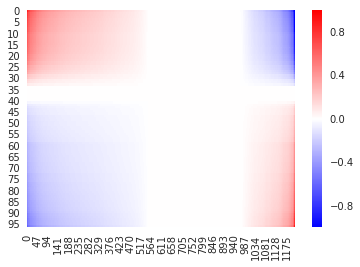

In [88]:
row_idx =  np.argsort(u)
col_nonzero = np.argsort(np.abs(v))
v_nonzero = v[col_nonzero]
first_nonzero = first[:,col_nonzero]
col_idx = np.argsort(v_nonzero)

ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')

## Plot

In [181]:
def plotClusters(u, s, v, group, tresh):
    first = s*u.reshape((-1, 1))@v.reshape((1, -1))

    groups = np.unique(group)
    row_idx = np.empty(0, dtype = 'int')
    for i in range(len(groups)):
        idx, = np.where(group == groups[i])
        idx_ = idx[np.argsort(u[idx])]
        row_idx = np.concatenate((row_idx, idx_))

    col_nonzero = np.argsort(np.abs(v))[tresh:]
    v_nonzero = v[col_nonzero]
    first_nonzero = first[:,col_nonzero]
    col_idx = np.argsort(v_nonzero)

    ax = sns.heatmap(first_nonzero[np.ix_(row_idx, col_idx)], vmin=-1, vmax=1, cmap = 'bwr')

In [ ]:
data = pd.read_csv('data/data.txt', sep=' ', header = None)
X = np.array(data.T)
u, s, v, niter = SSVD_primary(X)

In [182]:
groups = np.concatenate((np.ones(20), np.ones(33-20)*2, np.ones(50-33)*3, np.ones(56-50)*4))
plotClusters(u, s, v, groups, 8000)

ValueError: Cross index must be 1 dimensional

## Biclustering package

In [79]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

Text(0.5,1.05,'Original dataset')

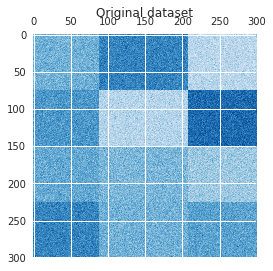

In [80]:
n_clusters = (4, 3)
data, rows, columns = make_checkerboard(
    shape=(300, 300), n_clusters=n_clusters, noise=10,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")

Text(0.5,1.05,'Shuffled dataset')

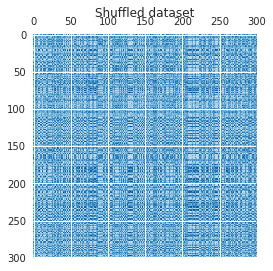

In [81]:
data, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

In [85]:
model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.1f}".format(score))

consensus score: 1.0


Text(0.5,1.05,'After biclustering; rearranged to show biclusters')

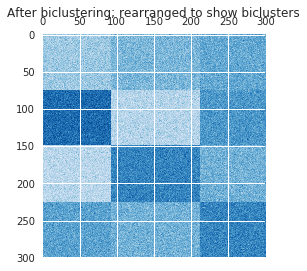

In [86]:
fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

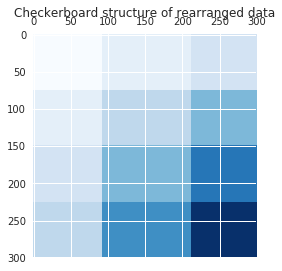

In [91]:
plt.matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

plt.show()